In [1]:
import numpy as np
import cv2
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time
from datetime import datetime
import keras_cv
import keras
from keras import ops
import tensorflow as tf
import glob as glob
import joblib
import warnings
warnings.filterwarnings('ignore')

2025-05-13 04:57:49.867568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747112270.064435      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747112270.120629      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class CFG:
    verbose = 1
    seed = 42
    preset = "efficientnetv2_b2_imagenet"
    image_size = [300,300] #224
    epochs = 10
    batch_size = 64 #256
    lr_mode = "cos"
    class_names = ["0","1","2","3","4"]
    num_classes = 5

In [3]:
keras.utils.set_random_seed(CFG.seed)

In [4]:
df = pd.read_csv("/kaggle/input/elm002/_label/智慧骑士_label/train.txt", sep="\t", header=None)
df[0] = '/kaggle/input/elm002/_train/智慧骑士_train/train/' + df[0]
df = df.rename(columns={df.columns[1]:'label'})
df

,0,label
0,/kaggle/input/elm002/_train/智慧骑士_train/train/5...,无风险
1,/kaggle/input/elm002/_train/智慧骑士_train/train/f...,无风险
2,/kaggle/input/elm002/_train/智慧骑士_train/train/7...,无风险
3,/kaggle/input/elm002/_train/智慧骑士_train/train/c...,无风险
4,/kaggle/input/elm002/_train/智慧骑士_train/train/4...,无风险
...,...,...
3360,/kaggle/input/elm002/_train/智慧骑士_train/train/a...,高风险
3361,/kaggle/input/elm002/_train/智慧骑士_train/train/d...,高风险
3362,/kaggle/input/elm002/_train/智慧骑士_train/train/9...,高风险
3363,/kaggle/input/elm002/_train/智慧骑士_train/train/1...,高风险


In [5]:
def is_valid_image(image_path):
    try:
        if not os.path.exists(image_path):
            return False
        image = cv2.imread(image_path)
        image = image.astype(np.uint8)
        return image is not None
    except Exception:
        return False

df = df[df[0].apply(is_valid_image)]

Corrupt JPEG data: 360156 extraneous bytes before marker 0xe2


In [6]:
df

,0,label
0,/kaggle/input/elm002/_train/智慧骑士_train/train/5...,无风险
1,/kaggle/input/elm002/_train/智慧骑士_train/train/f...,无风险
2,/kaggle/input/elm002/_train/智慧骑士_train/train/7...,无风险
3,/kaggle/input/elm002/_train/智慧骑士_train/train/c...,无风险
4,/kaggle/input/elm002/_train/智慧骑士_train/train/4...,无风险
...,...,...
3360,/kaggle/input/elm002/_train/智慧骑士_train/train/a...,高风险
3361,/kaggle/input/elm002/_train/智慧骑士_train/train/d...,高风险
3362,/kaggle/input/elm002/_train/智慧骑士_train/train/9...,高风险
3363,/kaggle/input/elm002/_train/智慧骑士_train/train/1...,高风险


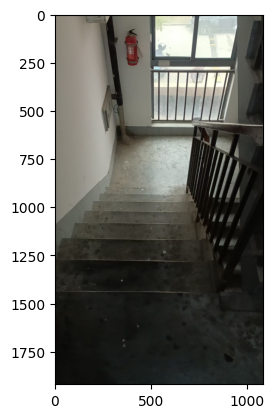

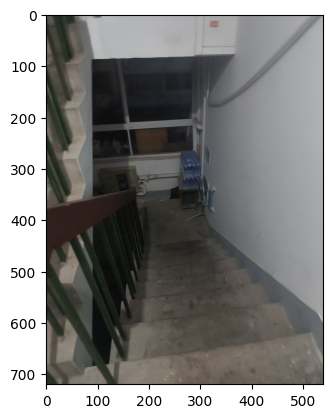

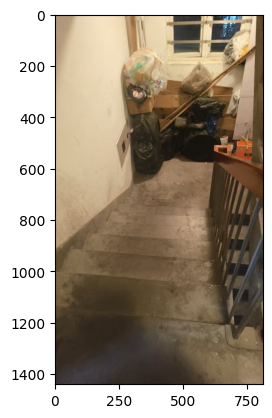

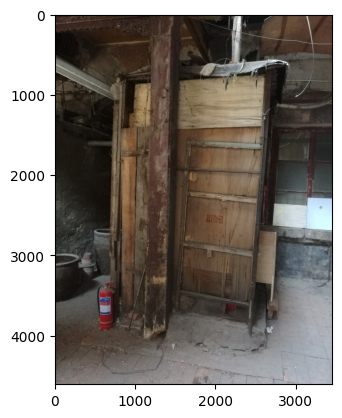

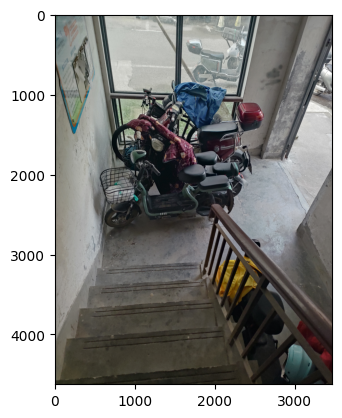

In [7]:
for lbl in df["label"].value_counts().index:
    img = cv2.imread(df[df["label"] == lbl][0].sample(1).values[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(img)

In [8]:
mapping_dict = {
    '高风险': 0,
    '中风险': 1,
    '低风险': 2,
    '无风险': 3,
    '非楼道': 4
}

df["label"] = df["label"].map(mapping_dict)

In [9]:
display(df["label"].value_counts(normalize=True)*100)

label
3    59.316493
2    18.900446
1    13.670134
4     4.962853
0     3.150074
Name: proportion, dtype: float64

In [10]:
#Before sampling, all the output results were '3' because the propotion of 3 in the dataset was too high.
a_df = df.query("label==0").sample(frac=12, replace=True, random_state=CFG.seed)
b_df = df.query("label==1").sample(frac=3, replace=True, random_state=CFG.seed)
c_df = df.query("label==2").sample(frac=2.8, replace=True, random_state=CFG.seed)
d_df = df.query("label==3").sample(frac=1,random_state=CFG.seed)
e_df = df.query("label==4").sample(frac=8,replace=True,random_state=CFG.seed)
df = pd.concat([a_df, b_df, c_df, d_df,e_df], axis=0).sample(frac=1.0)
display(df.label.value_counts(normalize=True)*100)

label
3    25.705087
2    22.936252
1    17.772054
4    17.205409
0    16.381198
Name: proportion, dtype: float64

In [11]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes = np.unique(df['label']), y=df['label'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.2209119496855345, 1: 1.1253623188405797, 2: 0.8719820325659742, 3: 0.7780561122244489, 4: 1.1624251497005988}


In [12]:
from sklearn.model_selection import StratifiedGroupKFold
groups = np.random.randint(0,10,7765)
df = df.reset_index(drop=True)
df["fold"] = -1
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)
for i ,(trian_idx, val_idx) in enumerate(sgkf.split(df[0].values, df.label, groups)):
    df.loc[val_idx, "fold"] = int(i)

train_df = df.query("fold!=0")
val_df = df.query("fold==0")
print(f"# Num Train:{len(train_df)} | Num Valid: {len(val_df)}")

# Num Train:6197 | Num Valid: 1568


In [13]:
train_df.label.value_counts()

label
3    1593
2    1451
1    1071
4    1066
0    1016
Name: count, dtype: int64

In [14]:
val_df.label.value_counts()

label
3    403
2    330
1    309
4    270
0    256
Name: count, dtype: int64

In [15]:
def build_augmenter():
    aug_layers = [
    keras_cv.layers.RandomRotation(factor=0.1),
    keras_cv.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    keras_cv.layers.RandomFlip(mode="horizontal"),
    keras_cv.layers.RandomCutout(height_factor=(0.02, 0.06), width_factor=(0.02, 0.06)),
    keras_cv.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    keras_cv.layers.RandomShear(x_factor=0.1, y_factor=0.1),
    keras_cv.layers.RandomBrightness(factor=0.05),
    keras_cv.layers.RandomSaturation(factor=0.05),
    ]

    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    def augment(images, label):
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        images = aug_data["images"]
        return images, label
    return augment

In [16]:
def build_dataset(
    df,
    labels=None,
    batch_size=32,
    augment_fn=None,
    augment=False,
    shuffle=1024,
    cache=True,
    drop_remainder=False,
):
   
    if augment_fn is None:
        augment_fn = build_augmenter()
        
    AUTO = tf.data.experimental.AUTOTUNE
   # for i,ID in enumerate(IDs):
    #    labels[i] = tf.one_hot(df['label'], CFG.num_classes)
    
    images = [] 
    for directory in df[0]:
        image = Image.open(directory).convert('RGB')
        image = image.resize(CFG.image_size)
        image_array = np.array(image)
        images.append(image_array)
    images = np.array(images).astype(np.uint8)
    
    labels = tf.one_hot(labels, CFG.num_classes)
  
    slices = (images, labels) if labels is not None else {"images":images}
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds
        

In [17]:
train_labels = train_df['label'].values
train_ds = build_dataset( train_df, train_labels, batch_size=CFG.batch_size,shuffle=True, augment=True)

I0000 00:00:1747112388.487782      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [18]:
val_labels = val_df.label.values
val_ds = build_dataset( val_df, val_labels, batch_size=CFG.batch_size, shuffle=False, augment=False)

In [19]:
batch = next(iter(train_ds))
print("Images:", batch[0].shape)
print("Labels:",batch[1].shape)

Images: (64, 300, 300, 3)
Labels: (64, 5)


In [20]:
auc = keras.metrics.AUC()
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.02)

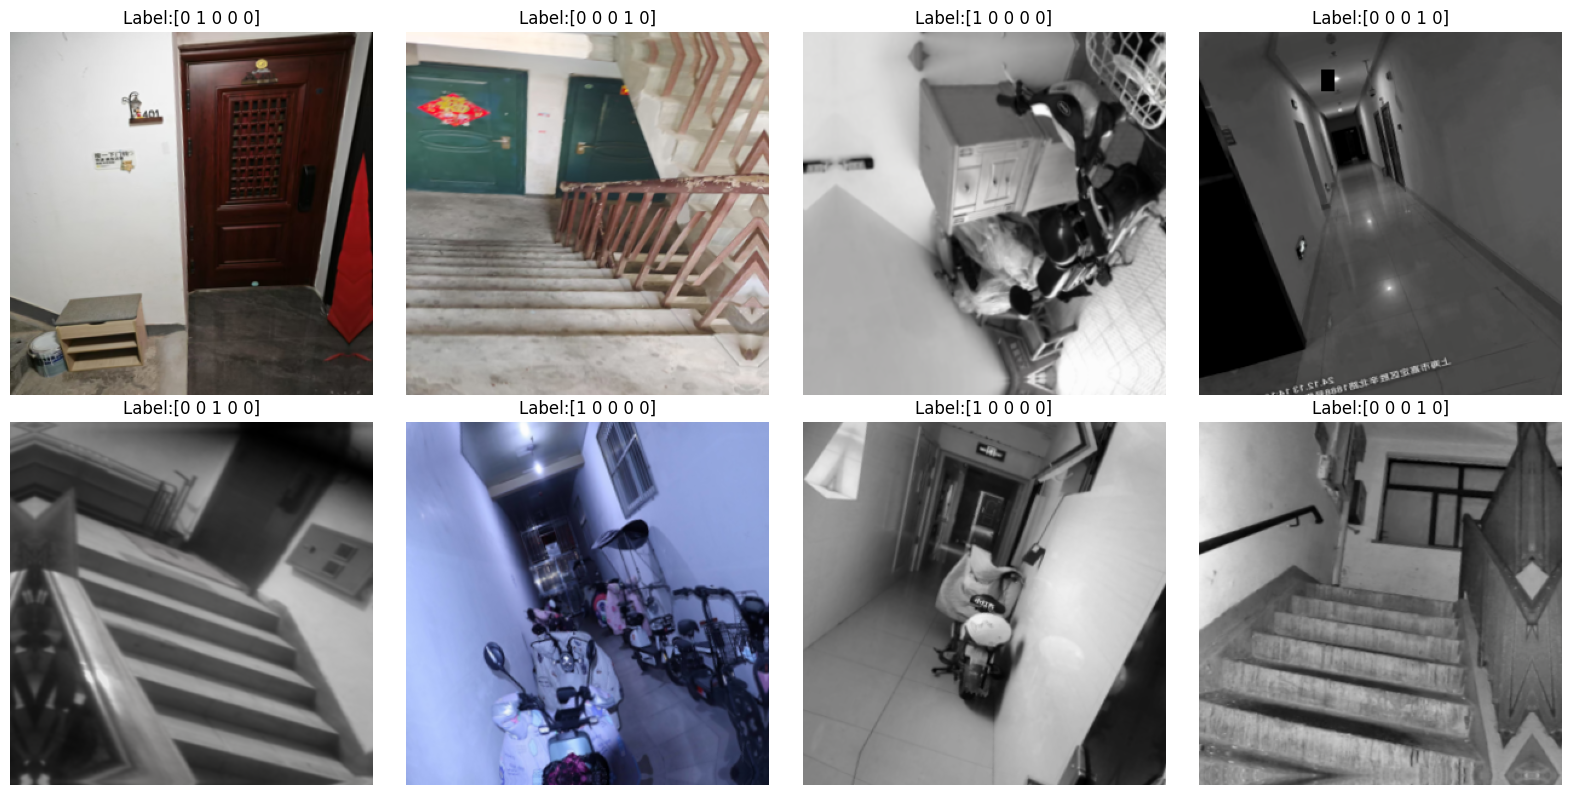

In [21]:
images, labels = next(iter(train_ds))
num_images, NUMERIC_COLUMNS = 8, 4
plt.figure(figsize=(4 * NUMERIC_COLUMNS, num_images // NUMERIC_COLUMNS * 4))
for i, (image, label) in enumerate(zip(images[:num_images], labels[:num_images])):
    plt.subplot(num_images // NUMERIC_COLUMNS, NUMERIC_COLUMNS, i+1)
    image = image.numpy().astype("float32")
    label = label.numpy().astype("int32")
    image = (image - image.min()) / (image.max() + 1e-4)
    plt.imshow(image)
    plt.title(f"Label:{label}")
    plt.axis("off")
plt.tight_layout()
plt.show()              

In [22]:
image_input = keras.Input(shape=(*CFG.image_size, 3),name="images")
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(CFG.preset)
x1 = backbone(image_input)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.Dropout(0.2)(x1)
out = keras.layers.Dense(5, activation="softmax",)(x1)
model = keras.models.Model(image_input, out)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss = loss,
    metrics=[auc],
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)                  │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficient_net_v2b2_backbone          │ (None, 10, 10, 1408)        │       8,769,374 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           7,045 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,776,419 (33.48 MB)

 Trainable params: 8,694,131 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [23]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 3e-5, 5e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 5, 0, 0.75
    def lrfn(epoch):
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif mode == 'exp': lr = (lr_max-lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()
    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)

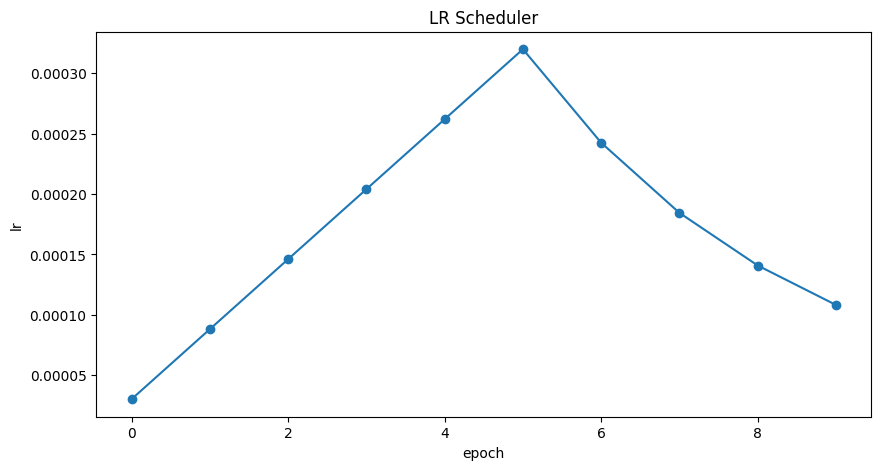

In [24]:
lr_cb = get_lr_callback(CFG.batch_size, mode="exp", plot=True)

In [25]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_auc",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
)

In [26]:
history = model.fit(
    train_ds,
    epochs = 15,
    callbacks=[lr_cb, ckpt_cb],
    validation_data = val_ds,
    verbose=CFG.verbose,
)

Epoch 1/15


I0000 00:00:1747112805.142864     102 service.cc:148] XLA service 0x7ab8833cebf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747112805.143933     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747112813.989947     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1747112833.785623     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747112833.980074     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747112834.611471     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747112834.8129

94/97 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - auc: 0.6241 - loss: 1.5618

E0000 00:00:1747113001.959354      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747113002.153534      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747113002.743251      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747113002.942945      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747113003.644980      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

97/97 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - auc: 0.6269 - loss: 1.5600 - val_auc: 0.7999 - val_loss: 1.4045 - learning_rate: 3.0000e-05
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - auc: 0.8221 - loss: 1.2773 - val_auc: 0.9149 - val_loss: 0.9180 - learning_rate: 8.8000e-05
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - auc: 0.9147 - loss: 0.8932 - val_auc: 0.9634 - val_loss: 0.6043 - learning_rate: 1.4600e-04
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - auc: 0.9564 - loss: 0.6518 - val_auc: 0.9796 - val_loss: 0.4672 - learning_rate: 2.0400e-04
Epoch 5/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - auc: 0.9751 - loss: 0.5138 - val_auc: 0.9890 - val_loss: 0.3677 - learning_rate: 2.6200e-04
Epoch 6/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - auc: 0.9852 - loss: 0.4162 - val_auc: 0.9925 - val_loss: 0.3196 - learning_rate: 3.2000e-04
Epoch 7/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - auc: 0.9908 - loss: 0.3484 - val_auc: 0.9951 - val_loss: 0.2700 - learning_rate: 2.4250e

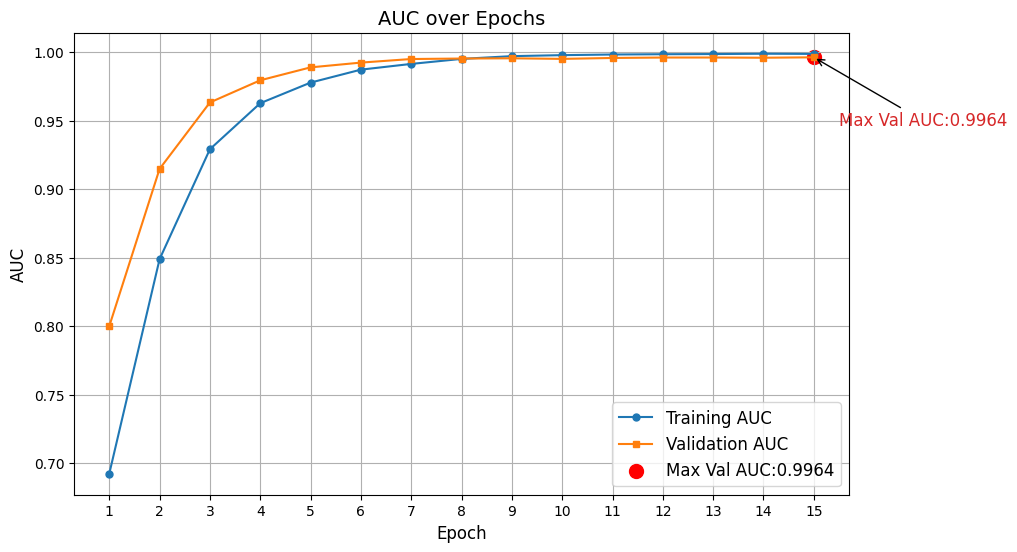

In [27]:
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)
max_val_auc_epoch = np.argmax(val_auc)
max_val_auc = val_auc[max_val_auc_epoch]

plt.figure(figsize=(10,6))
plt.plot(epochs, auc, 'o-', label="Training AUC", markersize=5, color='tab:blue')
plt.plot(epochs, val_auc, 's-', label='Validation AUC', markersize=5, color='tab:orange')
plt.scatter(max_val_auc_epoch + 1, max_val_auc, color='red', s=100, label=f'Max Val AUC:{max_val_auc:.4f}')
plt.annotate(f'Max Val AUC:{max_val_auc:.4f}', xy=(max_val_auc_epoch + 1, max_val_auc),
            xytext=(max_val_auc_epoch + 1 + 0.5, max_val_auc - 0.05),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=12, color='tab:red')
plt.title('AUC over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.xticks(epochs)
plt.show()


In [28]:
best_score = max(history.history['val_auc'])
best_epoch = np.argmax(history.history['val_auc']) + 1
print(f"Best AUC: {best_score:.5f}")
print(f"Best Epoch: {best_epoch}")

Best AUC: 0.99636
Best Epoch: 15


In [29]:
model.load_weights("best_model.keras")

In [30]:
test_df = pd.read_csv("/kaggle/input/test-b/label_B/B_new.txt", sep="\t", header=None)
test_df[0] = '/kaggle/input/test-b/B/B/' + test_df[0]
test_df["label"] = 1

In [31]:
test_df

,0,label
0,/kaggle/input/test-b/B/B/fb3468d90f9b3104eb582...,1
1,/kaggle/input/test-b/B/B/e504012009d0b4fb1d931...,1
2,/kaggle/input/test-b/B/B/cbbbfa2cfa44db22d8ba7...,1
3,/kaggle/input/test-b/B/B/ae057190d065b1d5aaec6...,1
4,/kaggle/input/test-b/B/B/ac68e5ed929907a0346ac...,1
...,...,...
722,/kaggle/input/test-b/B/B/a4c48ab5b237705d10bd8...,1
723,/kaggle/input/test-b/B/B/357e2ccb31ae1269f1a58...,1
724,/kaggle/input/test-b/B/B/e1afe313b53a3367605ca...,1
725,/kaggle/input/test-b/B/B/712fcd90df136e46a60da...,1


In [32]:
def test_dataset(
    df,
    labels=None,
    batch_size=32,
    augment_fn=None,
    augment=False,
    shuffle=1024,
    cache=True,
    drop_remainder=False,
):
    
    if augment_fn is None:
        augment_fn = build_augmenter()
        
    AUTO = tf.data.experimental.AUTOTUNE
  
    
    images = [] 
    for directory in df[0]:
        image = Image.open(directory).convert('RGB')
        image = image.resize(CFG.image_size)
        image_array = np.array(image)
        images.append(image_array)
    images = np.array(images).astype(np.uint8)
    
   
  
    slices = (images, labels) if labels is not None else {"images":images}
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds
        

In [33]:
test_ds = test_dataset( test_df, batch_size=CFG.batch_size, shuffle=False,augment=False, cache=False)

In [34]:
preds = model.predict(test_ds).squeeze()

12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 947ms/step


In [35]:
test_df["label"] = preds.tolist()

In [36]:
test_df.label.value_counts()

label
[0.0010348448995500803, 0.0017853296594694257, 0.004537621047347784, 0.9923315048217773, 0.0003106913063675165]     2
[0.0021952970419079065, 0.000968967389781028, 0.0002984245656989515, 0.1062418594956398, 0.8902955055236816]        2
[0.002780395094305277, 0.0033829950261861086, 0.10587635636329651, 0.8866052031517029, 0.0013551132287830114]       1
[0.022063829004764557, 0.0018128699157387018, 0.006785346660763025, 0.9681857228279114, 0.001152151613496244]       1
[0.006457299925386906, 0.07973597943782806, 0.4168296754360199, 0.4594431221485138, 0.03753393143415451]            1
                                                                                                                   ..
[0.5340569019317627, 0.08125992119312286, 0.2703273892402649, 0.09812307357788086, 0.016232695430517197]            1
[0.0009590396075509489, 0.5408669710159302, 0.45605966448783875, 0.0009478221763856709, 0.0011665396159514785]      1
[0.0009596331510692835, 0.0015028807101771235, 0.9

In [37]:
test_df["label"] = test_df["label"].apply(lambda x: np.argmax(x))

In [38]:
test_df

,0,label
0,/kaggle/input/test-b/B/B/fb3468d90f9b3104eb582...,3
1,/kaggle/input/test-b/B/B/e504012009d0b4fb1d931...,4
2,/kaggle/input/test-b/B/B/cbbbfa2cfa44db22d8ba7...,3
3,/kaggle/input/test-b/B/B/ae057190d065b1d5aaec6...,3
4,/kaggle/input/test-b/B/B/ac68e5ed929907a0346ac...,3
...,...,...
722,/kaggle/input/test-b/B/B/a4c48ab5b237705d10bd8...,3
723,/kaggle/input/test-b/B/B/357e2ccb31ae1269f1a58...,2
724,/kaggle/input/test-b/B/B/e1afe313b53a3367605ca...,3
725,/kaggle/input/test-b/B/B/712fcd90df136e46a60da...,4


In [39]:
test_df.label.value_counts()

label
3    437
1    137
2     76
4     52
0     25
Name: count, dtype: int64

In [40]:
inverse_mapping_dict = {v: k for k, v in mapping_dict.items()}
inverse_transform = np.vectorize(inverse_mapping_dict.get)

test_df["label"] = inverse_transform(test_df["label"])

In [41]:
test_df[0] = test_df[0].str.replace('/kaggle/input/test-b/B/B/','',regex=False)

test_df[[0, "label"]].to_csv("submit1.txt", index=None, sep="\t", header=None)

In [42]:
test_df

,0,label
0,fb3468d90f9b3104eb5826088f0106e1.jpg,无风险
1,e504012009d0b4fb1d93147ef637a9aa.jpg,非楼道
2,cbbbfa2cfa44db22d8ba72c250d65d27.jpg,无风险
3,ae057190d065b1d5aaec65e3d7675fc1.jpg,无风险
4,ac68e5ed929907a0346ac04706a84553.jpg,无风险
...,...,...
722,a4c48ab5b237705d10bd8dbdcca55bfe.jpg,无风险
723,357e2ccb31ae1269f1a58ed6f8b6380b.jpg,低风险
724,e1afe313b53a3367605ca4df02d88f82.jpg,无风险
725,712fcd90df136e46a60da16d6cf321fc.jpg,非楼道
